# Base Imports

In [1]:
% matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from limlam_mocker import limlam_mocker as llm
#Get Parameters for run
from limlam_mocker import params        as params

import lnn as lnn

%load_ext autoreload

In [10]:
%autoreload
# %autoreload 0
#%autoreload 2

# Setup Learning Environment

In [3]:
import tensorflow as tf
from tensorflow import keras

In [4]:
mapLoc = '../maps/test/'
catLoc = '../catalogues/'

In [5]:
### map info
numb_maps = 100
pix_x = 256
pix_y = 256

### output info
lum_func_size = 49

# Set Up the Model

In [11]:
model = keras.Sequential()
### convolutional layer
model.add(keras.layers.Conv2D(32, kernel_size=(5,5), strides=(1,1), activation='relu', input_shape=(pix_x, pix_y, numb_maps)))
### pooling layer
model.add(keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
### convolutional layer
model.add(keras.layers.Conv2D(64, (5, 5), activation='relu'))
### pooling layer
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
### flatten the network
model.add(keras.layers.Flatten())
### make a dense layer for the second to last step
model.add(keras.layers.Dense(1000, activation='relu'))
### finish it off with a dense layer with the number of output we want for our luminosity function
model.add(keras.layers.Dense(lum_func_size, activation='linear'))

In [12]:
model.compile(loss=keras.losses.logcosh, 
              optimizer=keras.optimizers.SGD(), 
              metrics=[keras.metrics.mse])

# Start Training the Network

In [15]:
### number of maps to look at in a batch
batch_size = 100
steps_per_epoch = 5
epochs = 10

subFields = lnn.loadBaseFNames(mapLoc)
base = [mapLoc + s for s in subFields]

dataset = tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(base))
dataset = dataset.shuffle(buffer_size=len(base))
dataset = dataset.map(lambda item: tuple(tf.py_func(lnn.utf8FileToMapAndLum, [item], [tf.float64, tf.float64])))
dataset = dataset.repeat()
dataset = dataset.batch(batch_size)

In [16]:
model.fit(dataset, epochs=epochs, steps_per_epoch=steps_per_epoch, verbose=1)

Epoch 1/10
5/5 [==============================] - 432s 86s/step - loss: 4.2342 - mean_squared_error: 26.3019
Epoch 2/10
5/5 [==============================] - 434s 87s/step - loss: 4.2319 - mean_squared_error: 26.2792
Epoch 3/10
5/5 [==============================] - 442s 88s/step - loss: 4.2325 - mean_squared_error: 26.2876
Epoch 4/10
5/5 [==============================] - 440s 88s/step - loss: 4.2305 - mean_squared_error: 26.2651
Epoch 5/10
5/5 [==============================] - 441s 88s/step - loss: 4.2284 - mean_squared_error: 26.2510
Epoch 6/10
5/5 [==============================] - 435s 87s/step - loss: 4.2267 - mean_squared_error: 26.2265
Epoch 7/10
5/5 [==============================] - 448s 90s/step - loss: 4.2258 - mean_squared_error: 26.2198
Epoch 8/10
5/5 [==============================] - 445s 89s/step - loss: 4.2249 - mean_squared_error: 26.2079
Epoch 9/10
5/5 [==============================] - 443s 89s/step - loss: 4.2232 - mean_squared_error: 26.1965
Epoch 10/10
5/5 [==

In [27]:
model.save('my_model.h5')

# See How Good the Model Is

In [35]:
testMap = lnn.fileToMapData(base[152] + '_map.npz')
testLum = lnn.logLumFunc(lnn.fileToLum(base[152] + '_lum.npz'))
baseMap2 = np.expand_dims(testMap, axis=0)
baseLum2 = np.expand_dims(testLum, axis=0)

newLum = model.predict(tf.convert_to_tensor(baseMap2), steps=1)
model.evaluate(tf.convert_to_tensor(baseMap2), tf.convert_to_tensor(baseLum2), steps=1, verbose=1)

1/1 [==============================] - 1s 1s/step


[4.2110600471496582, 26.049421310424805]

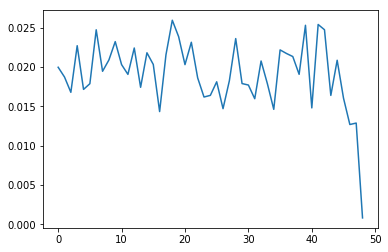

In [36]:
plt.plot(newLum[0])

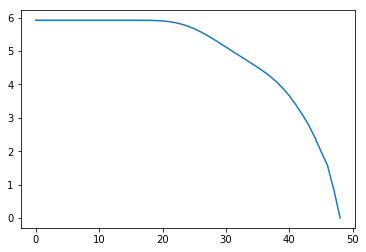

In [39]:
plt.plot(testLum)

# Test Making Dataset for training